In [1]:
# unzip the downloaded kaggle dataset
!unzip '/content/archive_Assn3.zip'

Archive:  /content/archive_Assn3.zip
  inflating: Google_Stock_Price_Test.csv  
  inflating: Google_Stock_Price_Train.csv  


### Imports

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Loading dataset

In [5]:
train_csv_path = "/content/Google_Stock_Price_Train.csv"
test_csv_path = "/content/Google_Stock_Price_Test.csv"
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

In [6]:
print(train_df.head())

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


In [7]:
print(test_df.head())

       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


## Visualisations

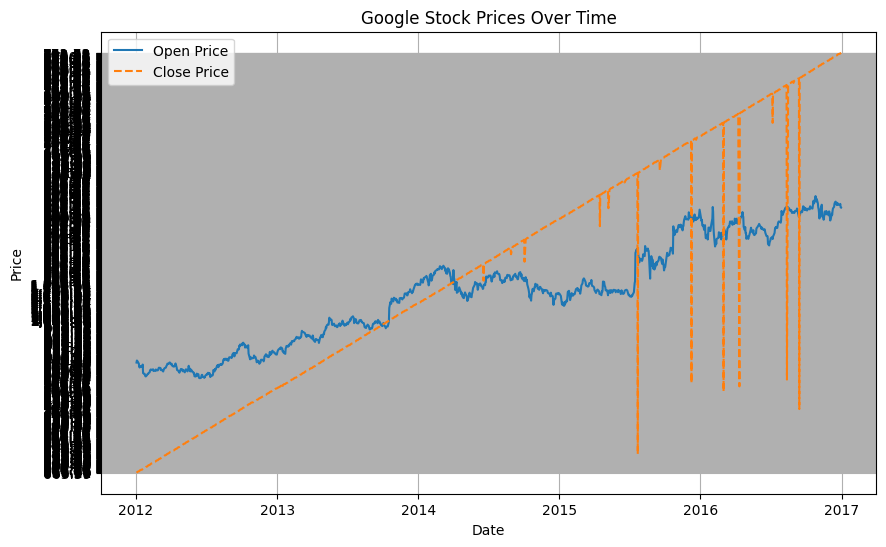

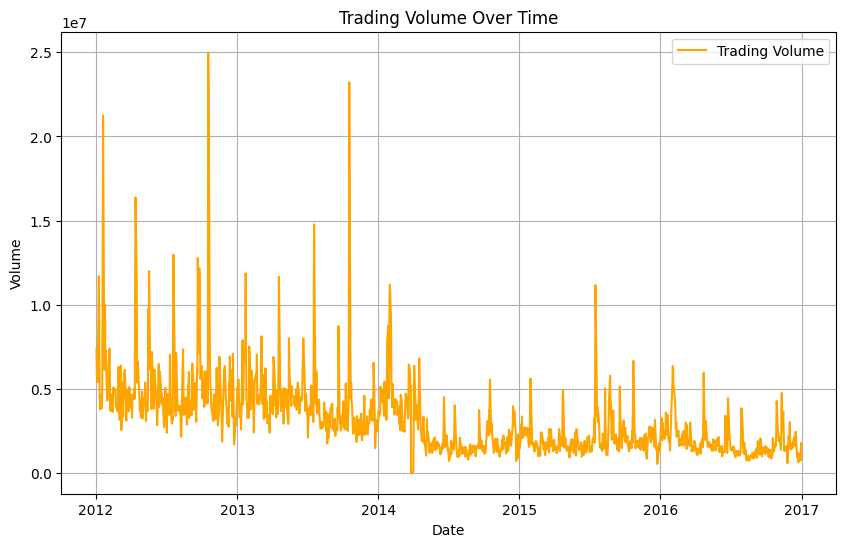

In [8]:
# Convert 'Date' column to datetime and sort the data by date
train_df['Date'] = pd.to_datetime(train_df['Date'], format='%m/%d/%Y')
train_df.sort_values(by='Date', inplace=True)

# Clean the 'Volume' column to convert it to numerical values (remove commas)
train_df['Volume'] = train_df['Volume'].str.replace(',', '').astype(float)

#  Stock prices over time
plt.figure(figsize=(10, 6))
plt.plot(train_df['Date'], train_df['Open'], label='Open Price')
plt.plot(train_df['Date'], train_df['Close'], label='Close Price', linestyle='--')
plt.title('Google Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Trading volume over time
plt.figure(figsize=(10, 6))
plt.plot(train_df['Date'], train_df['Volume'], color='orange', label='Trading Volume')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()


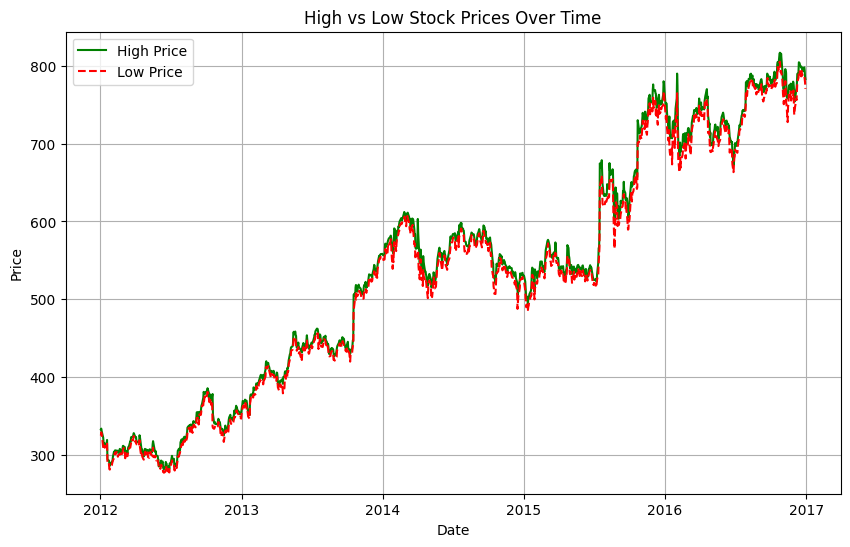

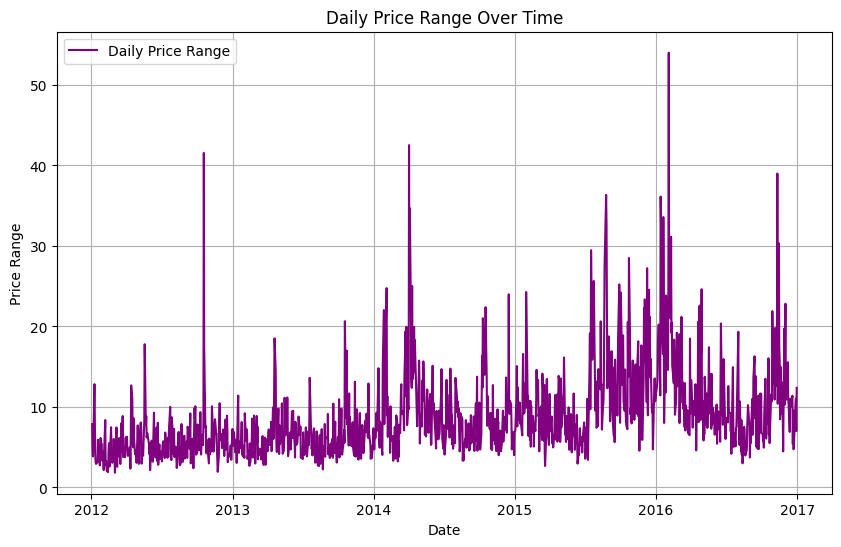

In [10]:
# High vs. Low Prices Over Time
plt.figure(figsize=(10, 6))
plt.plot(train_df['Date'], train_df['High'], label='High Price', color='green')
plt.plot(train_df['Date'], train_df['Low'], label='Low Price', color='red', linestyle='--')
plt.title('High vs Low Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Daily Price Range (High - Low)
train_df['Daily Range'] = train_df['High'] - train_df['Low']
plt.figure(figsize=(10, 6))
plt.plot(train_df['Date'], train_df['Daily Range'], color='purple', label='Daily Price Range')
plt.title('Daily Price Range Over Time')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.legend()
plt.grid(True)
plt.show()



## Cleaning and splitting

In [ ]:
# Clean the Close and Volume columns
def clean_data(df):
    # Check if 'Close' column is of type object (string) before applying str.replace
    if df['Close'].dtype == object:
      df['Close'] = pd.to_numeric(df['Close'].str.replace(',', ''), errors='coerce')
    # Check if 'Volume' column is of type object (string) before applying str.replace
    if df['Volume'].dtype == object:
      df['Volume'] = pd.to_numeric(df['Volume'].str.replace(',', ''), errors='coerce')

    df = df.dropna()
    return df

train_df = clean_data(train_df)
test_df = clean_data(test_df)

# Extract Close prices for prediction
train_prices = train_df['Close'].values.reshape(-1, 1)
test_prices = test_df['Close'].values.reshape(-1, 1)

# Normalize the Close prices
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices)
test_prices_scaled = scaler.transform(test_prices)

# Split Train Data into Train and Validation Sets
train_size = int(len(train_prices_scaled) * 0.80)  # 80-20 split
train_df = train_prices_scaled[:train_size]
val_data = train_prices_scaled[train_size:]

## Create sequence for RNN input and check shapes

In [ ]:
# Create sequences for RNN input
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Small seq_length
seq_length = 10  # Adjusted to fit test set
print(f"Adjusted seq_length: {seq_length}")

X_train, y_train = create_sequences(train_df, seq_length)
X_val, y_val = create_sequences(val_data, seq_length)
X_test, y_test = create_sequences(test_prices_scaled, seq_length)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Adjusted seq_length: 10
Shapes:
X_train: (996, 10, 1) y_train: (996, 1)
X_val: (242, 10, 1) y_val: (242, 1)
X_test: (10, 10, 1) y_test: (10, 1)


## Models

### Baseline RNN

In [ ]:
def baseline_model():
    model = Sequential([
        SimpleRNN(50, activation='tanh', return_sequences=False, input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

### Improved baseline RNN

In [ ]:
def improved_model():
    model = Sequential([
        SimpleRNN(100, activation='tanh', return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        SimpleRNN(50, activation='tanh', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

### LSTM

In [ ]:
def lstm():
    model = Sequential([
        LSTM(50, activation='tanh', return_sequences=False, input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

### GRU

In [ ]:
def gru():
    model = Sequential([
        GRU(50, activation='tanh', return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

### Bi-directional LSTM (BiLSTM)

In [ ]:
def bidirectional_lstm():
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh', return_sequences=False),
                      input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

### Bi-directional GRU (BiGRU)

In [ ]:
def bidirectional_gru():
    model = Sequential([
        Bidirectional(GRU(50, activation='tanh', return_sequences=False),
                      input_shape=(seq_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

## Train and eval

Training Baseline...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1225 - mae: 0.2278 - val_loss: 0.0071 - val_mae: 0.0784
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - mae: 0.0543 - val_loss: 0.0020 - val_mae: 0.0372
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - mae: 0.0311 - val_loss: 7.1034e-04 - val_mae: 0.0200
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0261 - val_loss: 5.6404e-04 - val_mae: 0.0177
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mae: 0.0220 - val_loss: 0.0011 - val_mae: 0.0269
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mae: 0.0270 - val_loss: 0.0011 - val_mae: 0.0260
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mae: 0.0212 - val_loss: 4.9409e-04 - val_mae: 0.0164
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - mae: 0.0255 - val_loss: 4.8800e-04 - val_mae: 0.0163
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 -

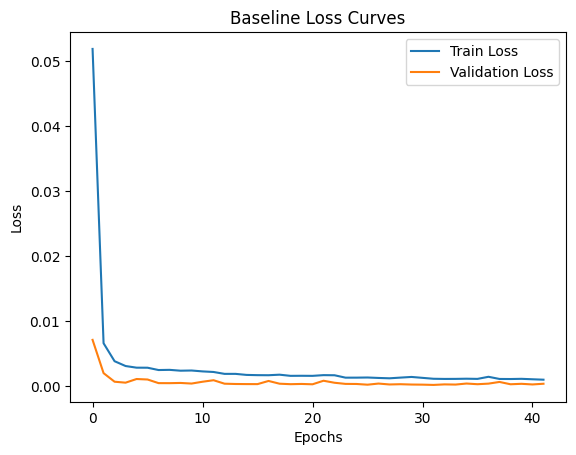

Training Improved baseline...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0561 - mae: 0.1717 - val_loss: 0.0023 - val_mae: 0.0428
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - mae: 0.0737 - val_loss: 0.0039 - val_mae: 0.0593
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0538 - val_loss: 0.0015 - val_mae: 0.0364
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - mae: 0.0424 - val_loss: 0.0018 - val_mae: 0.0383
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - mae: 0.0388 - val_loss: 7.7443e-04 - val_mae: 0.0236
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0355 - val_loss: 0.0011 - val_mae: 0.0301
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - mae: 0.0313 - val_loss: 2.2993e-04 - val_mae: 0.0112
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0343 - val_loss: 6.7466e-04 - val_mae: 0.0223
Epoch 9/50
32/32 ━━━━━━━━━━━

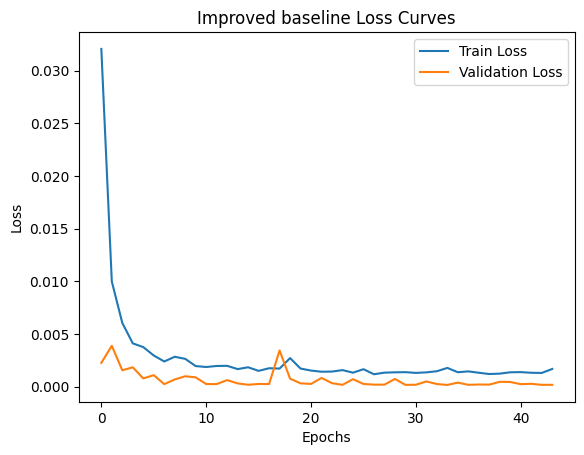

Training LSTM...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0309 - mae: 0.1194 - val_loss: 9.1847e-04 - val_mae: 0.0264
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0289 - val_loss: 6.7727e-04 - val_mae: 0.0217
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - mae: 0.0241 - val_loss: 5.6295e-04 - val_mae: 0.0178
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 - mae: 0.0284 - val_loss: 9.0333e-04 - val_mae: 0.0262
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0036 - mae: 0.0295 - val_loss: 6.9264e-04 - val_mae: 0.0223
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mae: 0.0247 - val_loss: 4.4887e-04 - val_mae: 0.0163
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mae: 0.0227 - val_loss: 4.8520e-04 - val_mae: 0.0166
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - mae: 0.0223 - val_loss: 4.2940e-04 - val_mae: 0.0160
Epoch 9/50
32/32 ━━━━━

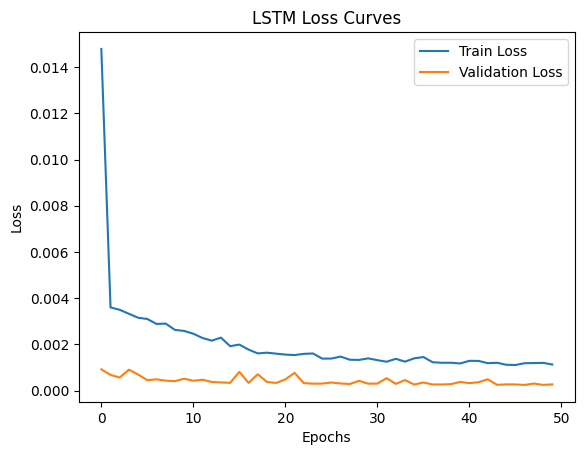

Training GRU...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0729 - mae: 0.1866 - val_loss: 8.0643e-04 - val_mae: 0.0216
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - mae: 0.0548 - val_loss: 6.0511e-04 - val_mae: 0.0206
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - mae: 0.0215 - val_loss: 3.3744e-04 - val_mae: 0.0137
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mae: 0.0197 - val_loss: 3.6996e-04 - val_mae: 0.0143
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3894e-04 - mae: 0.0173 - val_loss: 4.1360e-04 - val_mae: 0.0164
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013 - mae: 0.0184 - val_loss: 3.0834e-04 - val_mae: 0.0132
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - mae: 0.0169 - val_loss: 3.0331e-04 - val_mae: 0.0129
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0020 - mae: 0.0177 - val_loss: 2.9052e-04 - val_mae: 0.0127
Epoch 9/50
32/32 ━

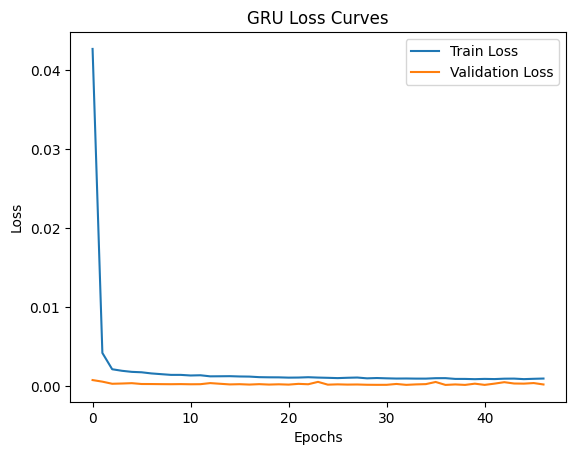

Training Bi-directional LSTM...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0542 - mae: 0.1569 - val_loss: 0.0011 - val_mae: 0.0288
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0049 - mae: 0.0345 - val_loss: 6.0471e-04 - val_mae: 0.0197
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0056 - mae: 0.0287 - val_loss: 5.8114e-04 - val_mae: 0.0193
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0029 - mae: 0.0255 - val_loss: 5.0094e-04 - val_mae: 0.0173
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - mae: 0.0254 - val_loss: 8.0991e-04 - val_mae: 0.0221
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mae: 0.0246 - val_loss: 5.4524e-04 - val_mae: 0.0189
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - mae: 0.0239 - val_loss: 5.5186e-04 - val_mae: 0.0178
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052 - mae: 0.0266 - val_loss: 4.7728e-04 - val_mae: 0.0165
Epoc

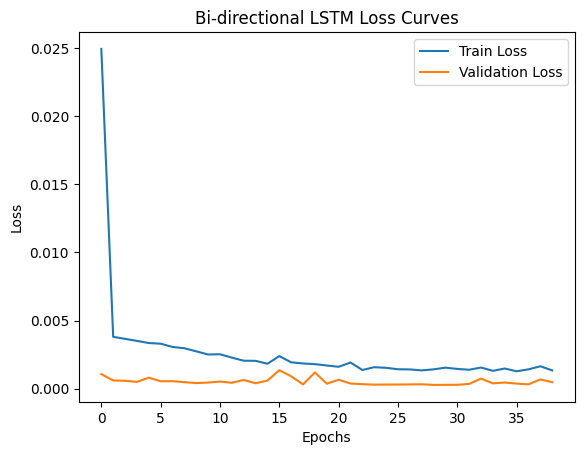

Training Bi-directional GRU...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0349 - mae: 0.1289 - val_loss: 0.0012 - val_mae: 0.0305
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - mae: 0.0308 - val_loss: 5.0485e-04 - val_mae: 0.0172
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0076 - mae: 0.0339 - val_loss: 4.9649e-04 - val_mae: 0.0170
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - mae: 0.0231 - val_loss: 4.9363e-04 - val_mae: 0.0168
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - mae: 0.0228 - val_loss: 4.6607e-04 - val_mae: 0.0176
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - mae: 0.0219 - val_loss: 3.4992e-04 - val_mae: 0.0144
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - mae: 0.0206 - val_loss: 3.2190e-04 - val_mae: 0.0135
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - mae: 0.0197 - val_loss: 3.5257e-04 - val_mae: 0.0142
Epoch

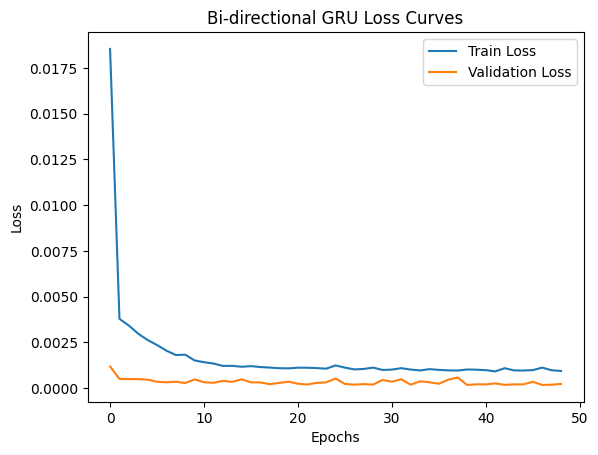

In [ ]:
# Train and Evaluate Models
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, callbacks=[early_stopping], verbose=1)

    # Plot training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model

models = {
    "Baseline": baseline_model(),
    "Improved baseline": improved_model(),
    "LSTM": lstm(),
    "GRU": gru(),
    "Bi-directional LSTM": bidirectional_lstm(),
    "Bi-directional GRU": bidirectional_gru()
}

trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    trained_models[name] = train_and_evaluate(model, X_train, y_train, X_val, y_val, name)

## Test

Testing Baseline...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
Test MSE: 0.0004, Test MAE: 0.0148


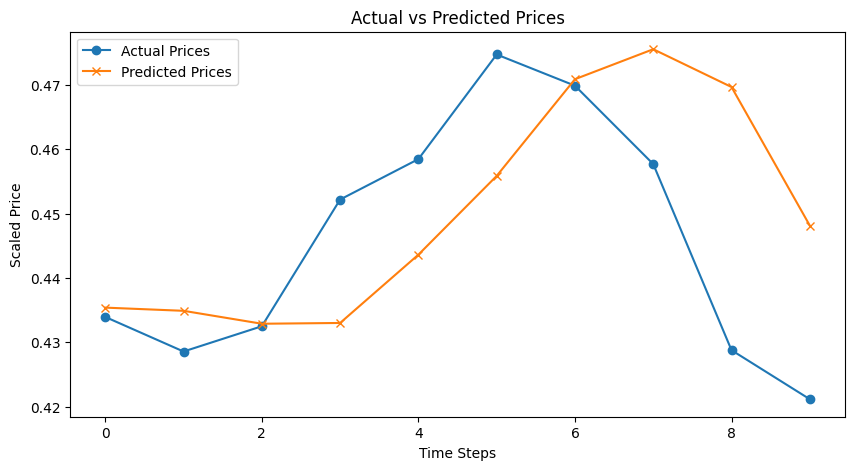

Testing Improved baseline...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Test MSE: 0.0002, Test MAE: 0.0112


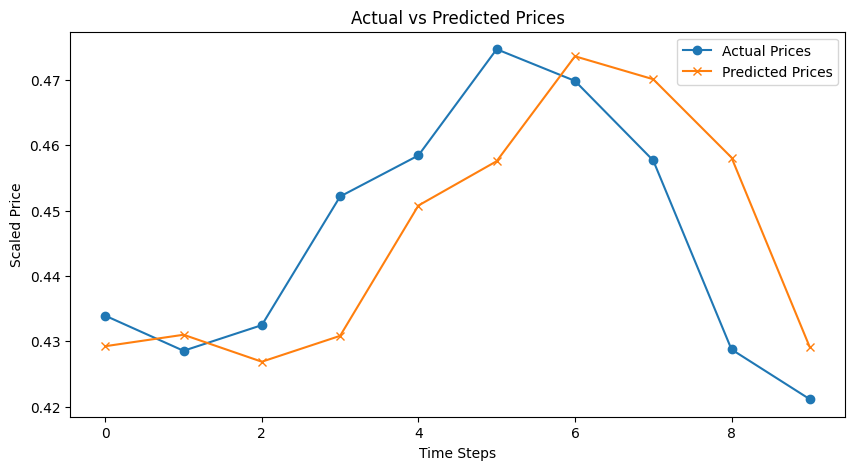

Testing LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Test MSE: 0.0004, Test MAE: 0.0159


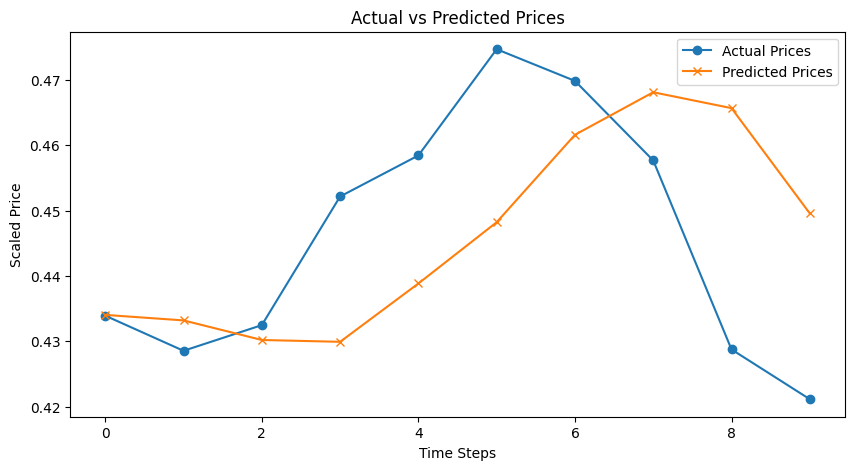

Testing GRU...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Test MSE: 0.0003, Test MAE: 0.0134


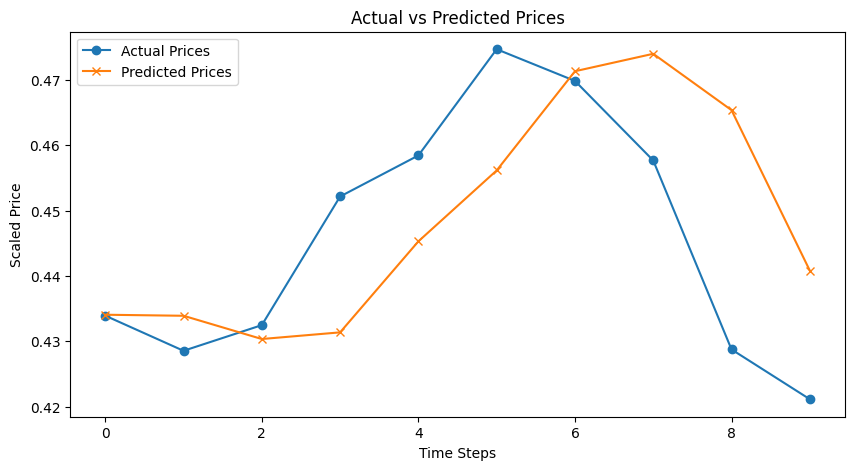

Testing Bi-directional LSTM...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Test MSE: 0.0005, Test MAE: 0.0178


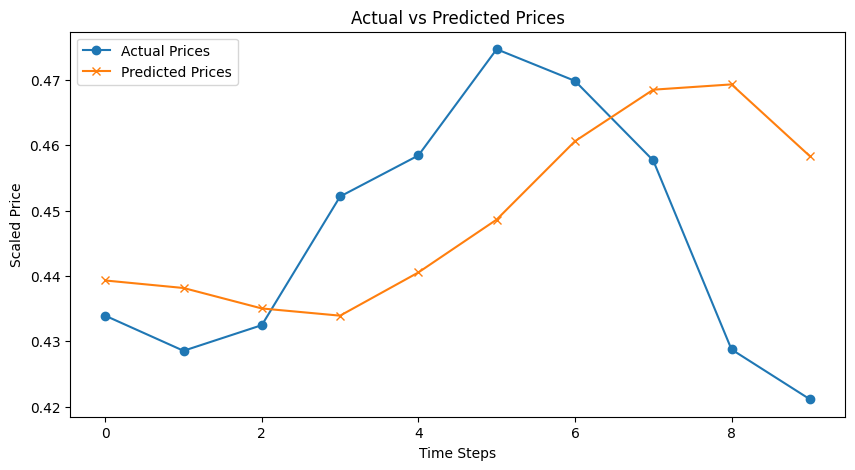

Testing Bi-directional GRU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
Test MSE: 0.0002, Test MAE: 0.0123


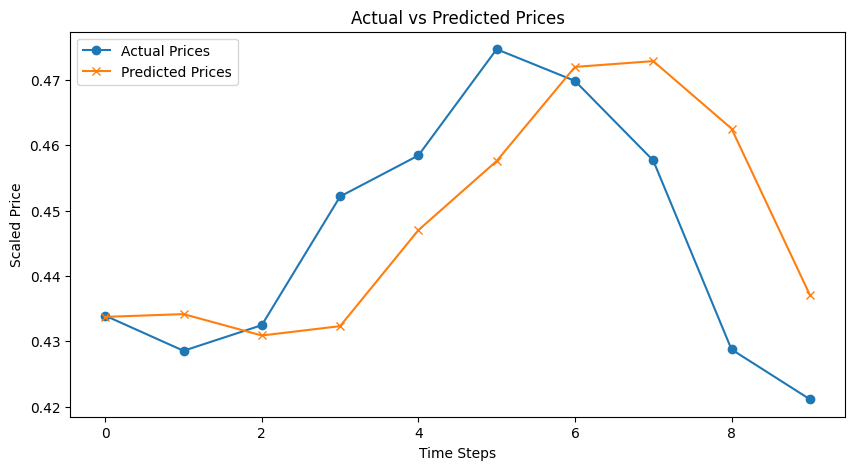

In [ ]:
# Evaluate Model on Test Set
def test_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    print(f"Test MSE: {mse:.4f}, Test MAE: {mae:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual Prices', marker='o')
    plt.plot(predictions, label='Predicted Prices', marker='x')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Scaled Price')
    plt.legend()
    plt.show()

    return mse, mae

# Test each model
for name, model in trained_models.items():
    print(f"Testing {name}...")
    test_model(model, X_test, y_test)

## Calculating directional accuracy

In [ ]:
def calculate_directional_accuracy(y_true, y_pred, last_known_values):
    # Determine the direction of price changes
    actual_direction = np.sign(y_true.flatten() - last_known_values.flatten())
    predicted_direction = np.sign(y_pred.flatten() - last_known_values.flatten())

    # Calculate the percentage of correctly predicted directions
    directional_accuracy = np.mean(actual_direction == predicted_direction)
    return directional_accuracy

# Calculate for each model
for name, model in trained_models.items():
    print(f"\nEvaluating directional accuracy for {name}...")
    predictions = model.predict(X_test)
    last_known_values = X_test[:, -1]  # The last value in each input sequence
    directional_accuracy = calculate_directional_accuracy(y_test, predictions, last_known_values)
    print(f"{name} directional accuracy: {directional_accuracy:.2f}")


Evaluating directional accuracy for Baseline...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Baseline directional accuracy: 0.40

Evaluating directional accuracy for Improved baseline...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Improved baseline directional accuracy: 0.20

Evaluating directional accuracy for LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM directional accuracy: 0.50

Evaluating directional accuracy for GRU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
GRU directional accuracy: 0.40

Evaluating directional accuracy for Bi-directional LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Bi-directional LSTM directional accuracy: 0.50

Evaluating directional accuracy for Bi-directional GRU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Bi-directional GRU directional accuracy: 0.30


## Calculating autocorrelation of residuals

Residual analysis for Baseline...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


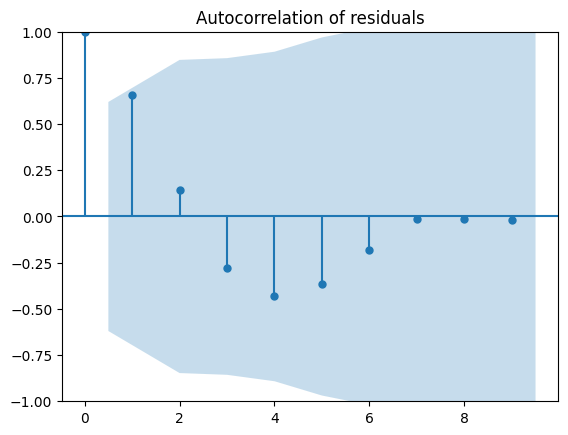

Residual analysis for Improved baseline...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


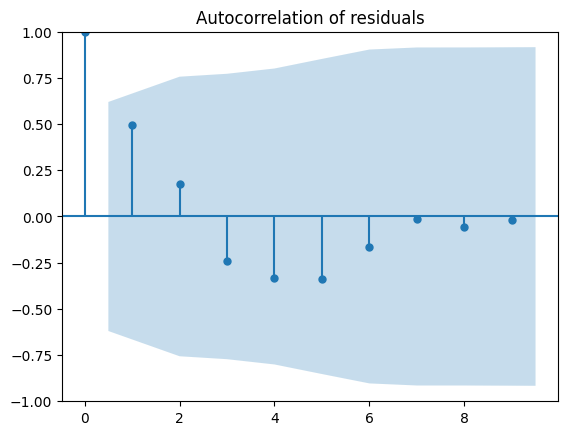

Residual analysis for LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


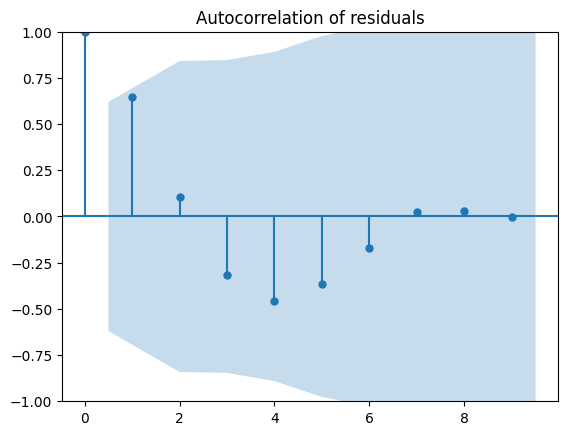

Residual analysis for GRU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


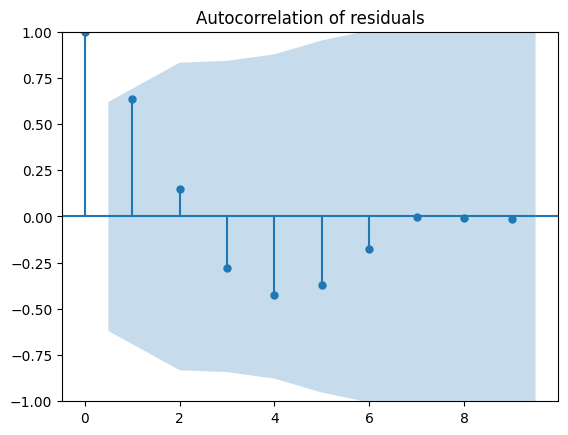

Residual analysis for Bi-directional LSTM...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


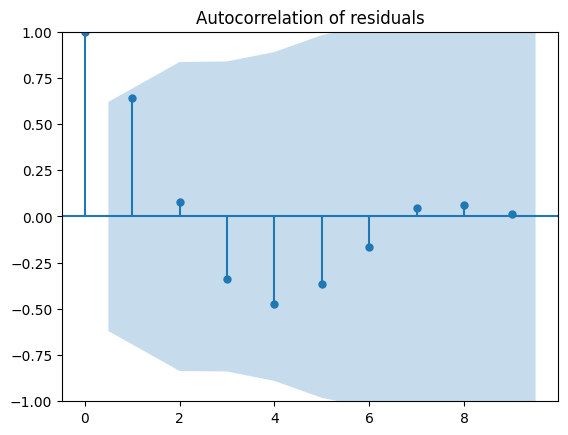

Residual analysis for Bi-directional GRU...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


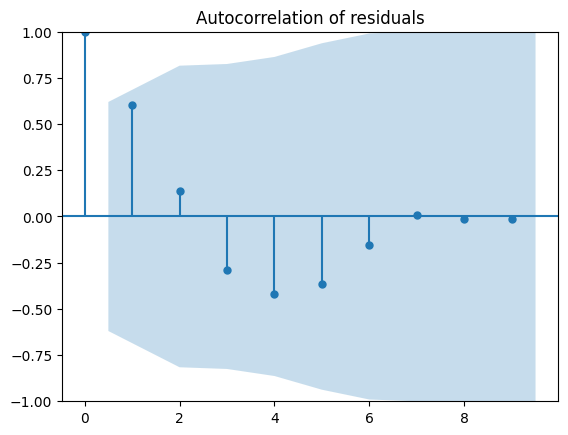

In [ ]:
def plot_residuals_autocorrelation(y_true, y_pred):
    # Calculate residuals
    residuals = y_true.flatten() - y_pred.flatten()

    # Plot autocorrelation of residuals
    plot_acf(residuals, lags=9)
    plt.title("Autocorrelation of residuals")
    plt.show()

# Plot for each model
for name, model in trained_models.items():
    print(f"Residual analysis for {name}...")
    predictions = model.predict(X_test)
    plot_residuals_autocorrelation(y_test, predictions)